Initializing Geocodio client...
Successfully loaded 7 addresses from '../input/addresses.csv'.
Attempting to geocode 7 addresses and retrieve congressional districts...
Geocoding request successful.
Processing geocoding results...
Extracting districts from 2 results for query: 1600 Amphitheatre Pkwy, Mountain View, CA 94043
Extracting districts from 2 results for query: 157 Irene Ct, Mountain View, CA 94043
Extracting districts from 2 results for query: 1075 Space Park Way, Mountain View, CA 94043
Extracting districts from 1 results for query: 1 Hacker Way, Menlo Park, CA 94025
Extracting districts from 1 results for query: 1 Infinite Loop, Cupertino, CA 95014
Extracting districts from 3 results for query: 350 5th Ave, New York, NY 10118
Extracting districts from 2 results for query: 11 W 32nd St, New York, NY 10001

Successfully mapped 7 addresses to 4 districts.
Calculating district frequencies...

District Frequency Counts:
CA-16    3
NY-12    2
CA-15    1
CA-17    1
Name: count, dt

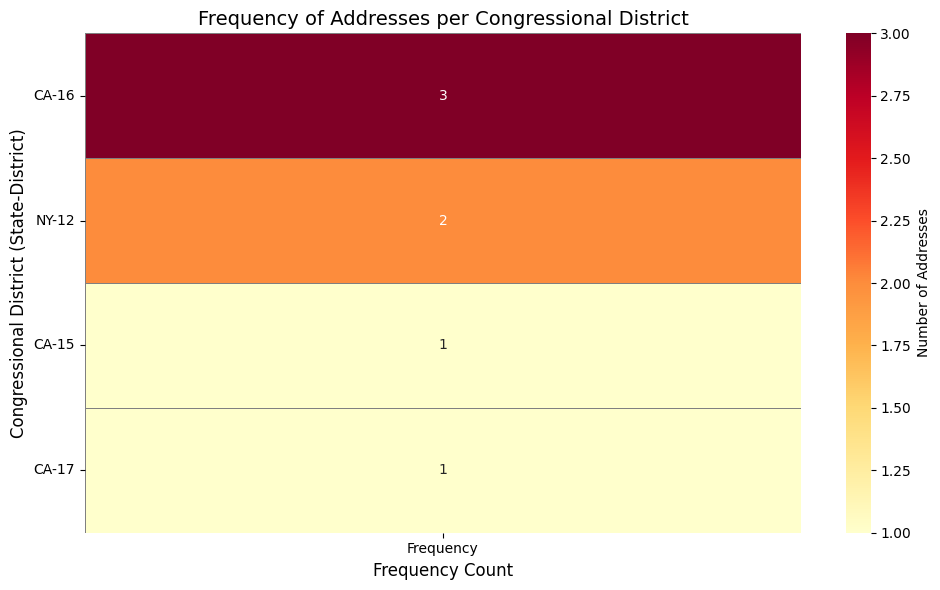


Script finished.


In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geocodio import GeocodioClient
from geocodio.exceptions import GeocodioError, GeocodioAuthError, GeocodioDataError, GeocodioServerError

# --- Configuration ---
load_dotenv() # Load environment variables from .env file
API_KEY = os.getenv('GEOCODIO_API_KEY', 'NO_API_KEY')
ADDRESSES_FILE_PATH = os.getenv('ADDRESSES_FILE_PATH', '../input/addresses.csv')
ADDRESS_COLUMN_NAME = os.getenv('ADDRESS_COLUMN_NAME', 'address')

# --- Helper Functions ---
def load_addresses_from_csv(file_path, column_name):
    """
    Reads addresses from a CSV file and returns them as a list.
    Handles errors such as file not found or missing column.

    Args:
        file_path (str): Path to the CSV file.
        column_name (str): Name of the column containing addresses.

    Returns:
        list: A list of addresses or an empty list if an error occurs.
    """
    try:
        # Load the CSV file into a DataFrame
        addresses_df = pd.read_csv(file_path)
        # Extract the addresses from the specified column
        addresses = addresses_df[column_name].dropna().tolist()
        print(f"Successfully loaded {len(addresses)} addresses from '{file_path}'.")
        return addresses
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except KeyError:
        print(f"Error: The column '{column_name}' does not exist in the CSV file.")
    except Exception as e:
        print(f"An unexpected error occurred while reading the CSV file: {e}")
    return []

def extract_districts(response):
    """
    Extracts state and district number from a Geocodio result object.

    This function processes a Geocodio response object to extract unique
    congressional district identifiers. It handles potential errors,
    missing data, and at-large districts (represented as 'AL').

    Returns:
        list: A list of unique district ID strings (e.g., ['VA-8', 'VA-AL']).
              Returns an empty list or None if no valid districts are found.
    """
    if not response or not hasattr(response, 'get'): # Check if response is valid
        input = response.get('input') if response and hasattr(response, 'get') else 'Unknown Address'
        query = input.get('formatted_address') if input and hasattr(input, 'get') else 'Unknown Address'
        print(f"No input. Skipping invalid response for query: {query}")
        return None

    query = response.get('input').get('formatted_address') # Get the original address query

    if 'results' not in response or not response.get('results') \
        or not isinstance(response.get('results'), list):
        print(f"No results. Skipping invalid response for query: {query}")
        return None

    print(f"Extracting districts from {len(response.get('results'))} results for query: {query}")

    district_ids = [] # List to store unique district IDs

    for result in response.get('results'):
        # Check if the result is a valid Geocodio object
        if not result or not hasattr(result, 'get'):
            print(f"Not a dict. Skipping invalid result for query: {query}")
            continue

        try:
            # Check for errors reported by Geocodio for this specific address
            if result.get('error'):
                print(f"Skipping result with Geocoding error for '{query}': {result.get('error')}")
                continue

            # Get state from main address components
            address_components = result.get('address_components', {})
            state = address_components.get('state')

            # Get congressional district info from fields
            fields_data = result.get('fields', {})
            congressional_districts = fields_data.get('congressional_districts', [])

            if state and congressional_districts and isinstance(congressional_districts, list):
                for district in congressional_districts:
                    # Use the first district in the list (usually the most relevant)
                    district_number = district.get('district_number')

                    # Handle states with a single at-large district (often numbered 0 or 98)
                    if district_number is not None:
                        # Format consistently, e.g., using 'AL' for At-Large
                        district_label = 'AL' if district_number in [0,98] else str(district_number)
                        district_ids.append(f"{state}-{district_label}")
            else:
                # If state or district info is missing after successful geocode
                print(f"Warning: Missing state or district info for successfully geocoded address: {query}")

        except (AttributeError, IndexError, TypeError, KeyError) as e:
            # Catch potential parsing errors
            print(f"Skipping result. Error parsing district info for query '{query}': {e}")
            continue
    return set(district_ids)

# --- Main Execution ---
if __name__ == "__main__":
    if API_KEY == 'NO_API_KEY':
        print("Error: Please set 'GEOCODIO_API_KEY' environment variable to your actual Geocodio API key.")
        exit()

    print("Initializing Geocodio client...")
    client = GeocodioClient(API_KEY)

    input_addresses = load_addresses_from_csv(ADDRESSES_FILE_PATH, ADDRESS_COLUMN_NAME)
    print(f"Attempting to geocode {len(input_addresses)} addresses and retrieve congressional districts...")
    if len(input_addresses) > 99:
        print("Warning: Geocoding more than 100 addresses may exceed Geocodio's batch limit. Proceed with caution.")
        print("IMPORTANT: Remember the Geocodio API Free tier only includes 2500 lookups/day.")

    geocoded_addresses = None
    try:
        # Perform batch geocoding requesting congressional district field ('cd')
        geocoded_addresses = client.geocode(input_addresses, fields=['cd'])
        print("Geocoding request successful.")
    except GeocodioAuthError:
        print("Authentication Error: Invalid API Key.")
        exit()
    except GeocodioDataError as e:
        print(f"Data Error: Problem with input addresses - {e}")
        exit()
    except GeocodioServerError as e:
        print(f"Server Error: Geocodio server issue - {e}")
        exit()
    except GeocodioError as e:
        print(f"Geocodio Error: An unspecified error occurred - {e}")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during geocoding: {e}")
        exit()

    # --- Process Results and Extract Districts ---
    district_list = []
    if geocoded_addresses:
        print("Processing geocoding results...")
        for response in geocoded_addresses:
            unique_ids = extract_districts(response)
            if unique_ids:
                district_list.extend(unique_ids)
    else:
        print("No results returned from geocoding request.")

    # --- Calculate Frequencies ---
    if district_list:
        print(f"\nSuccessfully mapped {len(input_addresses)} addresses to {len(set(district_list))} districts.")
        print("Calculating district frequencies...")
        district_series = pd.Series(district_list)
        frequency_counts = district_series.value_counts()
        print("\nDistrict Frequency Counts:")
        print(frequency_counts)
    else:
        print("\nNo addresses were successfully mapped to districts. Cannot calculate frequencies.")
        frequency_counts = pd.Series(dtype=int)

    # --- Prepare Data for Heatmap ---
    if not frequency_counts.empty:
        print("\nPreparing data for heatmap visualization...")
        # Convert Series to DataFrame for heatmap input
        heatmap_data = frequency_counts.to_frame(name='Frequency')
        # Sort by frequency (descending) for better visualization
        heatmap_data = heatmap_data.sort_values(by='Frequency', ascending=False)
        print("Data ready for heatmap.")
    else:
        print("No frequency data to visualize.")
        heatmap_data = pd.DataFrame()

    # --- Generate and Display Heatmap ---
    if not heatmap_data.empty:
        print("Generating heatmap...")
        try:
            # Dynamically adjust height based on number of districts
            num_districts = len(heatmap_data)
            fig_height = max(6, num_districts * 0.35) # Adjust multiplier for spacing
            plt.figure(figsize=(10, fig_height))

            sns.heatmap(
                heatmap_data,
                annot=True,       # Show frequency values
                fmt="d",          # Integer format for annotations
                cmap='YlOrRd',    # Yellow-to-red colormap
                linewidths=.5,    # Lines between cells
                linecolor='grey', # Line color
                cbar=True,        # Show color bar
                cbar_kws={'label': 'Number of Addresses'} # Color bar label
            )

            plt.title('Frequency of Addresses per Congressional District', fontsize=14)
            plt.xlabel('Frequency Count', fontsize=12)
            plt.ylabel('Congressional District (State-District)', fontsize=12)
            plt.xticks(rotation=0)
            plt.yticks(rotation=0)
            plt.tight_layout()
            print("Displaying heatmap...")
            plt.show()
        except Exception as e:
            print(f"An error occurred during heatmap generation: {e}")
    else:
        print("Cannot generate heatmap: No data available.")

    print("\nScript finished.")